In [141]:
import sys
import os
import scipy.io
import numpy as np
import json
import matplotlib.pyplot as plt
from IPython.display import clear_output
%matplotlib inline
from PIL import Image
import tifffile

import dataclasses

In [2]:
# Add the common directory to path
sys.path.append(os.path.abspath('../common'))

# Import the common functions
from lidarMath import vmag


In [102]:
class LidarJsonStruct:
    # Constructor (initialization) method
    def __init__(self):
        # Instance attributes (unique to each instance)
        self.trajectoryStr = []
        self.sampleNum = []
        self.timestamp = []
        self.imageName = []

In [120]:
import json
from dataclasses import dataclass, field, asdict
from typing import List


@dataclass
class LidarEntry:
    """Represents a single lidar data entry"""
    trajectoryStr: str
    sampleNum: int
    timestamp: float
    imageName: str


@dataclass
class LidarJsonStruct:
    """Collection of lidar data entries that can be serialized to JSON"""
    entries: List[LidarEntry] = field(default_factory=list)
    
    def add_entry(self, trajectory_str: str, sample_num: int, 
                 timestamp: float, image_name: str) -> None:
        """Add a new entry to the lidar data structure"""
        entry = LidarEntry(
            trajectoryStr=trajectory_str,
            sampleNum=sample_num,
            timestamp=timestamp,
            imageName=image_name
        )
        self.entries.append(entry)
    
    def to_json(self, indent=4) -> str:
        """Convert the entire structure to a JSON string"""
        return json.dumps(asdict(self), indent=indent)
    
    def save_to_file(self, filename: str) -> None:
        """Save the structure to a JSON file"""
        with open(filename, 'w') as f:
            f.write(self.to_json())
    
    @classmethod
    def from_json(cls, json_str: str) -> 'LidarJsonStruct':
        """Create a LidarJsonStruct from a JSON string"""
        data = json.loads(json_str)
        result = cls()
        
        for entry_data in data['entries']:
            result.add_entry(
                entry_data['trajectoryStr'],
                entry_data['sampleNum'],
                entry_data['timestamp'],
                entry_data['imageName']
            )
        return result
    
    @classmethod
    def load_from_file(cls, filename: str) -> 'LidarJsonStruct':
        """Load a LidarJsonStruct from a JSON file"""
        with open(filename, 'r') as f:
            return cls.from_json(f.read())

In [121]:

lidar

LidarJsonStruct(entries=[])

In [122]:
lidarDataPath = "/home/julian/sandbox/datasets/vt-lidar/All_estimation_input_data_DoubleLoop/"
lidarDataFiles = sorted(os.listdir(lidarDataPath))

In [123]:
fileIdx = 0
lidarMatData = scipy.io.loadmat("".join([lidarDataPath, lidarDataFiles[fileIdx]]))

# lidarStruct = [[] for _ in range(lidarDataFiles.__len__())]


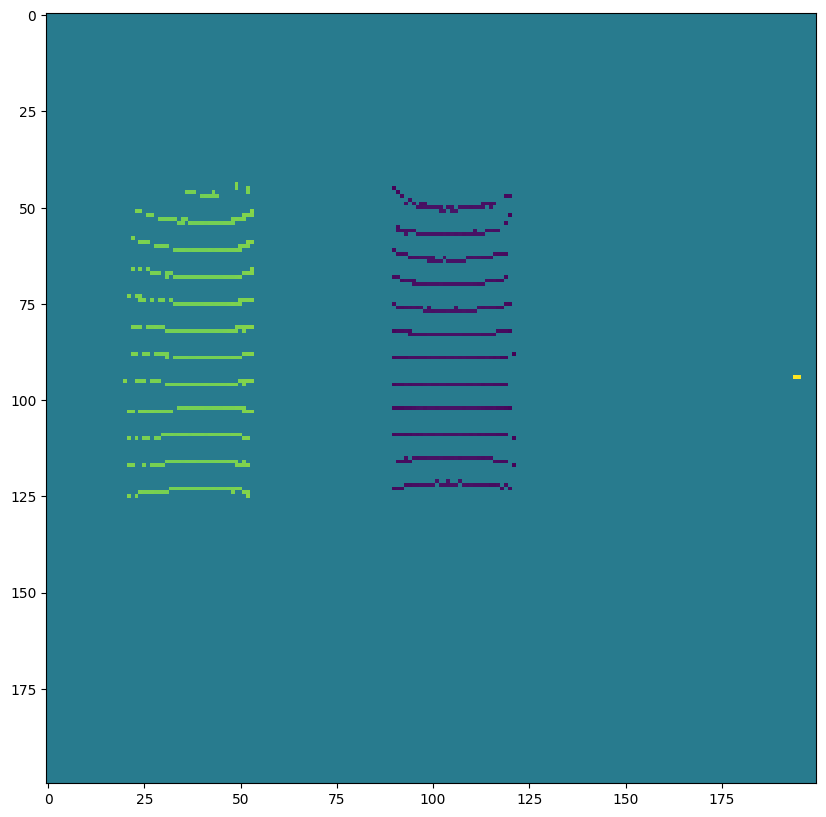

In [152]:
# Create an empty list that will hold dictionaries
lidar = LidarJsonStruct()

# Map the test data to new variable names
lidarData = lidarMatData['LiDARpc']
viconData = lidarMatData['VICONpc']

# Start Time
startTime = 14.7
startIdx = 148
finalIdx = 148 + 202 -1 
finalIdx = 148 + 5

# Fetch the number of indices in the lidar test data
numLidarIdx = np.size(lidarData, 1)
numLidarScan = numLidarIdx

timestampIdx = 0
lidarXIdx = 5
lidarYIdx = 6
lidarZIdx = 7

normPts = 2000

img_row = 200; img_col = 200
principalPoint = np.array([(img_row-1) / 2, (img_col-1) / 2])

# Define the rotation angle
rot_ang = -np.pi / 2

# Define the rotation matrix
mRotImg = np.array([[np.cos(rot_ang), -np.sin(rot_ang)], [np.sin(rot_ang), np.cos(rot_ang)]])

# Create figure and axis
plt.figure(figsize=(10, 10))

trajStr = lidarDataFiles[fileIdx][:-4]

for dataIdx in range(startIdx, finalIdx):
  # Initialize the lidar image
  lidar2DImg = np.zeros([img_row, img_col])


  # Pull the timestamp
  timestampLidar = lidarMatData['LiDARpc'][dataIdx,0][:,timestampIdx]

  # Pull the point cloud
  ptCloud = np.array([lidarMatData['LiDARpc'][dataIdx,0][:,lidarXIdx], 
                      lidarMatData['LiDARpc'][dataIdx,0][:,lidarYIdx], 
                      lidarMatData['LiDARpc'][dataIdx,0][:,lidarZIdx]])

  ptCloud = ptCloud / normPts

  for ptIdx in range(ptCloud.shape[1]):
    pt = ptCloud[:,ptIdx]
    ptImg = np.int32(np.floor(pt[[0,2]] @ mRotImg * np.array([img_row, img_col]) + principalPoint))

    if ((ptImg[0] >= 0) & (ptImg[0] < img_row)):
      if ((ptImg[1] >= 0) & (ptImg[1] < img_col)):
        if (lidar2DImg[ptImg[0],ptImg[1]] == 0):
          lidar2DImg[ptImg[0],ptImg[1]] = pt[1]
        elif (np.abs(pt[1]) < np.abs(lidar2DImg[ptImg[0],ptImg[1]])):
          lidar2DImg[ptImg[0],ptImg[1]] = pt[1]


  # Pull the nth closest point clouds
  imgStr = trajStr + '_sample_' + str(dataIdx) + '.tiff'
  lidar.add_entry(lidarDataFiles[fileIdx], dataIdx, np.mean(timestampLidar), imgStr)

  # write the image data
  writePath = './images/' + imgStr
  tifffile.imwrite(writePath, lidar2DImg)

  # Clear previous output
  clear_output(wait=True)
  
  plt.clf()
  # Show the project lidar points
  plt.imshow(lidar2DImg)

  # This ensures the plot is displayed during the loop

  plt.draw()
  display(plt.gcf())

plt.close('all') 

lidar.save_to_file('lidar_data.json')


In [145]:
['./images' + imgStr]

['./imagesPointsExtraAssoc_07122020onehr_01_sample_148.tiff']

In [133]:
trajStr = lidarDataFiles[fileIdx][:-4]
imgStr = trajStr + '_sample_' + str(dataIdx) + '.tif'
imgStr 

'PointsExtraAssoc_07122020onehr_01_sample_148.tif'

In [107]:
lidar

In [109]:
with open('data.json', 'w') as json_file:
    json.dump(
        lidar, 
        json_file,
        indent=4,
        ensure_ascii=False,  # For proper handling of non-ASCII characters
        sort_keys=True  # Optional: alphabetically sort the keys
    )

TypeError: Object of type LidarJsonStruct is not JSON serializable